# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

# Import Libraries

In [272]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [208]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
!kaggle datasets download -d khaledzsa/traffic-dataset
!unzip traffic-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/traffic-dataset
License(s): unknown
traffic-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  traffic-dataset.zip
replace Traffic Data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [291]:
df = pd.read_csv('/content/Traffic Data.csv', parse_dates=['date_time'], index_col='date_time')
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2017-08-27 01:00:00,1209.0,291.15,0.0,0.0,90,Mist,mist
2018-09-06 23:00:00,1248.0,286.01,0.0,0.0,1,Clear,sky is clear
2017-08-25 18:00:00,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds
2017-11-09 22:00:00,2838.0,262.35,0.0,0.0,1,Clear,sky is clear
2017-11-09 15:00:00,5794.0,267.08,0.0,0.0,5,Clear,sky is clear
...,...,...,...,...,...,...,...
2018-06-06 21:00:00,2723.0,296.42,0.0,0.0,40,Clouds,scattered clouds
2017-10-25 15:00:00,5895.0,285.58,0.0,0.0,40,Clouds,scattered clouds
2018-03-28 23:00:00,1132.0,275.30,0.0,0.0,1,Clear,sky is clear


##### **After loading the data I made a quick EDA**

In [292]:
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2017-08-27 01:00:00,1209.0,291.15,0.0,0.0,90,Mist,mist
2018-09-06 23:00:00,1248.0,286.01,0.0,0.0,1,Clear,sky is clear
2017-08-25 18:00:00,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds
2017-11-09 22:00:00,2838.0,262.35,0.0,0.0,1,Clear,sky is clear
2017-11-09 15:00:00,5794.0,267.08,0.0,0.0,5,Clear,sky is clear


In [293]:
df.tail()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2018-06-06 21:00:00,2723.0,296.42,0.0,0.0,40,Clouds,scattered clouds
2017-10-25 15:00:00,5895.0,285.58,0.0,0.0,40,Clouds,scattered clouds
2018-03-28 23:00:00,1132.0,275.30,0.0,0.0,1,Clear,sky is clear
2018-02-12 15:00:00,5525.0,260.94,0.0,0.0,75,Clouds,broken clouds
2018-05-31 18:00:00,5042.0,301.65,0.0,0.0,40,Clouds,scattered clouds


In [294]:
df.sample()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2016-11-22 15:00:00,4686.0,274.28,0.0,0.0,90,Fog,fog


In [295]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20000 entries, 2017-08-27 01:00:00 to 2018-05-31 18:00:00
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19980 non-null  float64
 1   temp                 20000 non-null  float64
 2   rain_1h              20000 non-null  float64
 3   snow_1h              20000 non-null  float64
 4   clouds_all           20000 non-null  int64  
 5   weather_main         20000 non-null  object 
 6   weather_description  20000 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.2+ MB


In [296]:
df.describe()
# I noticed that 'snow_1h' column values are all zeros, so I dropped it in the 'data splitting' section

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,19980.000000,20000.000000,20000.000000,20000.0,20000.000000
mean,3278.186887,281.162680,0.048396,0.0,49.384600
std,1977.171357,12.661288,0.398007,0.0,39.647341
min,113.000000,243.390000,0.000000,0.0,0.000000
25%,1228.750000,271.950000,0.000000,0.0,1.000000
50%,3430.000000,281.825000,0.000000,0.0,75.000000
75%,4928.000000,291.840000,0.000000,0.0,90.000000
max,16781.000000,310.070000,10.600000,0.0,92.000000


In [297]:
# Double Check
df['snow_1h'].value_counts()

,count
snow_1h,
0.0,20000


In [298]:
df.dtypes

,0
traffic_volume,float64
temp,float64
rain_1h,float64
snow_1h,float64
clouds_all,int64
weather_main,object
weather_description,object


In [299]:
df.isna().sum()

,0
traffic_volume,20
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


In [300]:
df.duplicated().sum()

18

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [301]:
# I recommended to apply data preprocessing before visualizing the data (in the next step) so that the visuals become clear, more reliable in addition to avoiding error in visualization due to null values

### **Handling null and duplicates**

In [302]:
df.isna().sum()

,0
traffic_volume,20
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


In [303]:
df['traffic_volume'] = df['traffic_volume'].fillna(df['traffic_volume'].mean())

In [304]:
df.isna().sum()

,0
traffic_volume,0
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


In [305]:
df.duplicated().sum()

18

In [306]:
df = df.drop_duplicates()

### **Create new feature (lags)**

In [307]:
df['Lag_2_Days'] = df['traffic_volume'].shift(2)  # I chosed the previous 2 days

<ipython-input-307-8e089835c72b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lag_2_Days'] = df['traffic_volume'].shift(2)  # I chosed the previous 2 days


In [308]:
# The new created feature contain nulls so I dropped them
df = df.dropna()

### **Make sure that the dates are sorted correctly**

In [309]:
df = df.sort_values(by='date_time', ascending=True)

In [310]:
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,Lag_2_Days
date_time,,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Mist,mist,316.0
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Fog,fog,2716.0
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Snow,heavy snow,3893.0
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Mist,mist,353.0
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Snow,heavy snow,2915.0
...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,3543.0,283.45,0.0,0.0,75,Clouds,broken clouds,4425.0
2018-09-30 20:00:00,2781.0,282.76,0.0,0.0,90,Clouds,overcast clouds,2517.0
2018-09-30 21:00:00,2159.0,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,6232.0


### **Handling categorical values**



In [311]:
df['weather_main'].value_counts()

,count
weather_main,
Clear,5605
Clouds,5231
Mist,2754
Rain,2244
Snow,1461
Drizzle,992
Haze,672
Thunderstorm,541
Fog,477


In [312]:
df = df[df['weather_main'] != 'Smoke'] # Smoke weather condition is only 3 values so I filtered them out

In [313]:
# Checking that is dropped correctly
df['weather_main'].value_counts()

,count
weather_main,
Clear,5605
Clouds,5231
Mist,2754
Rain,2244
Snow,1461
Drizzle,992
Haze,672
Thunderstorm,541
Fog,477


<ipython-input-314-7916af14d827>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='weather_main', y='traffic_volume', data=df, ci=None)


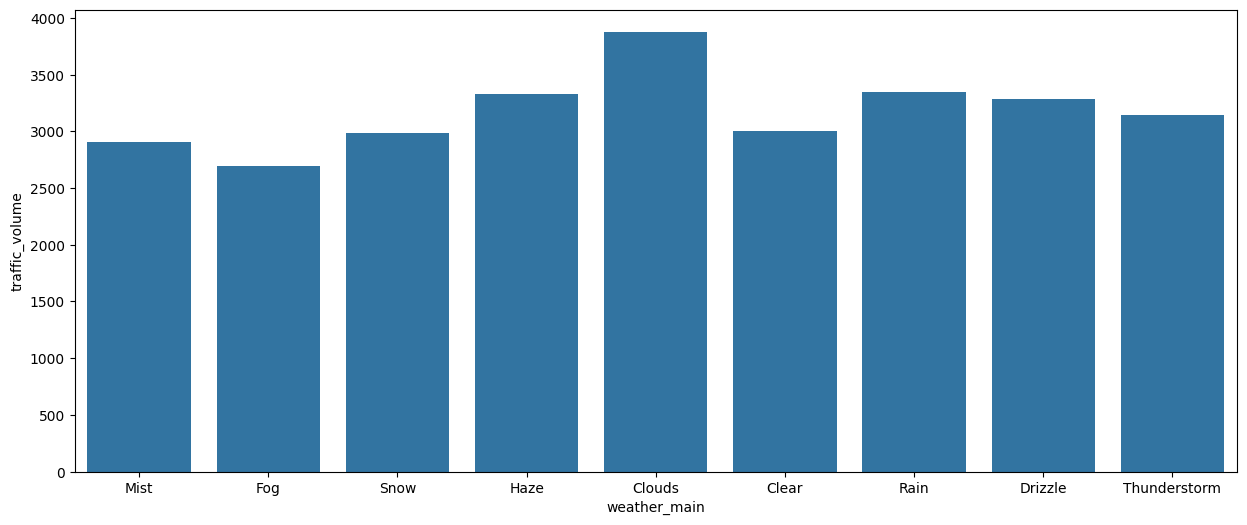

In [314]:
plt.figure(figsize=(15, 6))
sns.barplot(x='weather_main', y='traffic_volume', data=df, ci=None)
plt.show()
#It locks that 'cloudy' weather condition is the one with higher traffic volume

In [315]:
label_encoder = LabelEncoder()
df['weather_main'] = label_encoder.fit_transform(df['weather_main'])

<ipython-input-315-d05e7d705ef6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weather_main'] = label_encoder.fit_transform(df['weather_main'])


In [316]:
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,Lag_2_Days
date_time,,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,5,mist,316.0
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,3,fog,2716.0
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,7,heavy snow,3893.0
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,5,mist,353.0
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,7,heavy snow,2915.0
...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,3543.0,283.45,0.0,0.0,75,1,broken clouds,4425.0
2018-09-30 20:00:00,2781.0,282.76,0.0,0.0,90,1,overcast clouds,2517.0
2018-09-30 21:00:00,2159.0,282.73,0.0,0.0,90,8,proximity thunderstorm,6232.0


## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

### **Plot the time series data**

In [317]:
# Here I used a subset of the data for plotting so that the graphs become more readable
subset = df.head(1000)

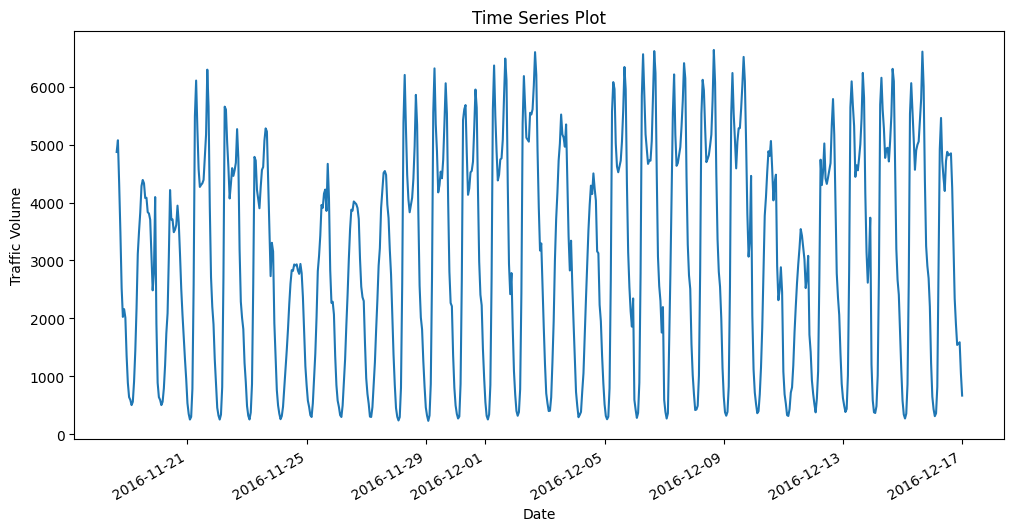

In [318]:
subset['traffic_volume'].plot(figsize=(12, 6))
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.show()

# It seems that data is seasonal

### **Analyze trends and seasonality**

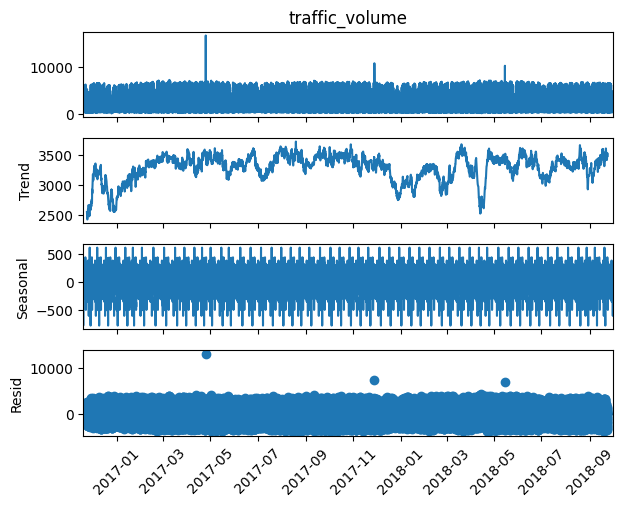

In [319]:
result = seasonal_decompose(df['traffic_volume'], model='additive', period=365)
result.plot()
plt.xticks(rotation=45)
plt.show()

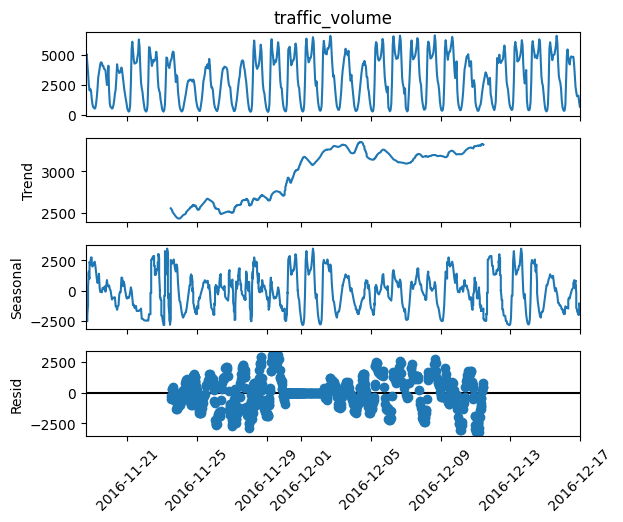

In [320]:
# I plotted both the whole df and the subset
result_subset = seasonal_decompose(subset['traffic_volume'], model='additive', period=365)
result_subset.plot()
plt.xticks(rotation=45)
plt.show()

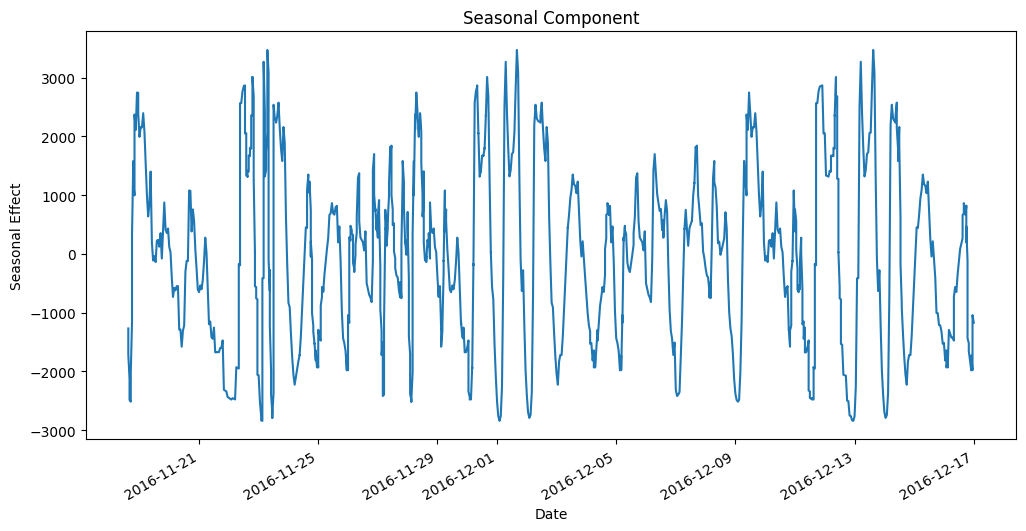

In [321]:
seasonal = result_subset.seasonal
seasonal.plot(figsize=(12, 6))
plt.title('Seasonal Component')
plt.xlabel('Date')
plt.ylabel('Seasonal Effect')
plt.show()

<ipython-input-322-19837d52dc4f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df.index.year
<ipython-input-322-19837d52dc4f>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Year', y='traffic_volume', data=df, ci= None)


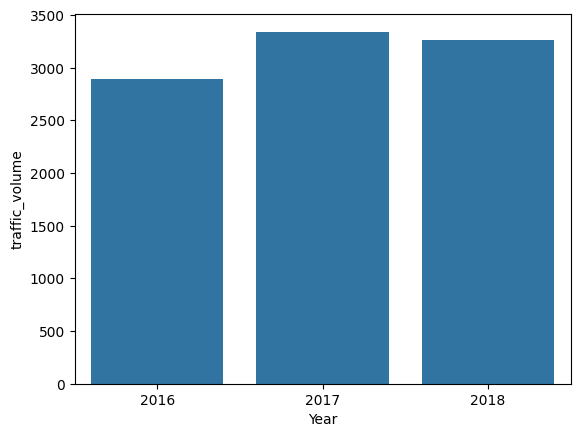

In [322]:
# I extracted the year to understand the traffic volume in each year
df['Year'] = df.index.year
sns.barplot(x='Year', y='traffic_volume', data=df, ci= None)
plt.show()

#It locks that '2017' has higher traffic volume than 2016 and 2018 but it's near to 2018

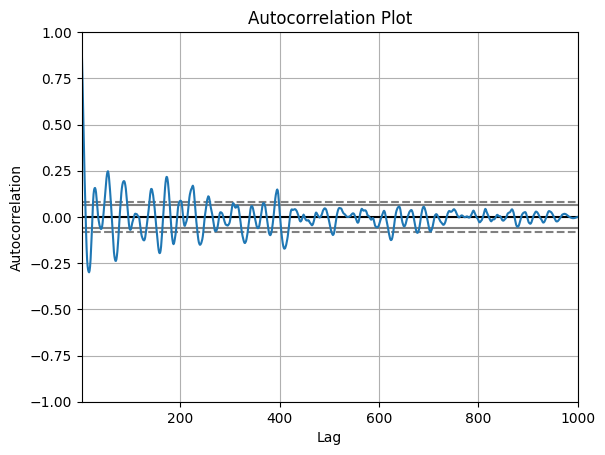

In [323]:
autocorrelation_plot(subset['traffic_volume'])
plt.title('Autocorrelation Plot')
plt.show()
# The following graph show that the lags under 200 are slightly correlated which mean that their next values are near to each other
# This is on a subset of data not the whole dataframe just to take a lock

### **Outliers Detection and Handling**

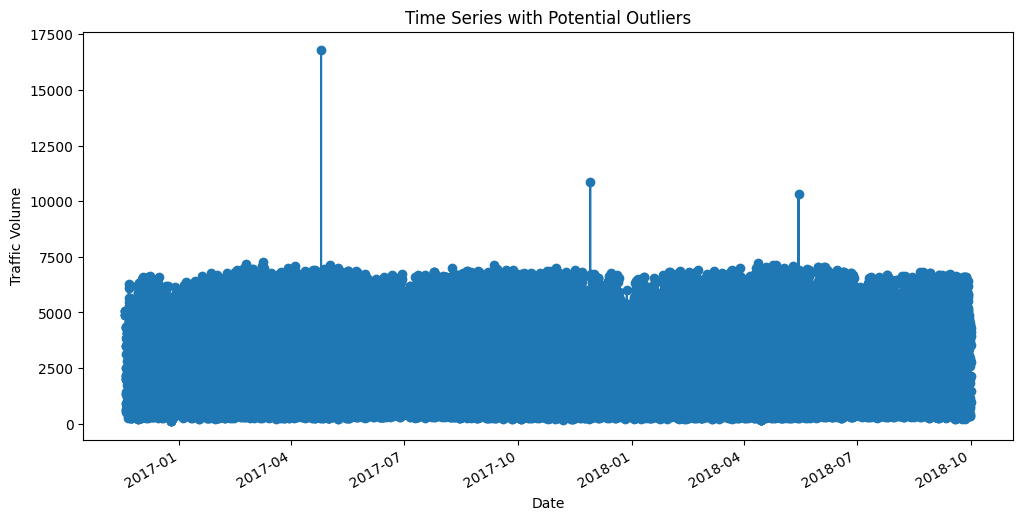

In [324]:
df['traffic_volume'].plot(figsize=(12, 6), marker='o', linestyle='-')
plt.title('Time Series with Potential Outliers')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.show()

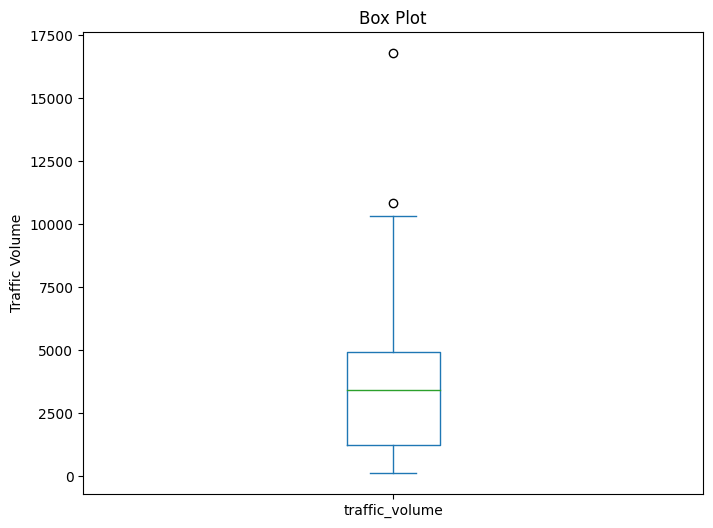

In [325]:
df['traffic_volume'].plot(kind='box', figsize=(8, 6))
plt.title('Box Plot')
plt.ylabel('Traffic Volume')
plt.show()

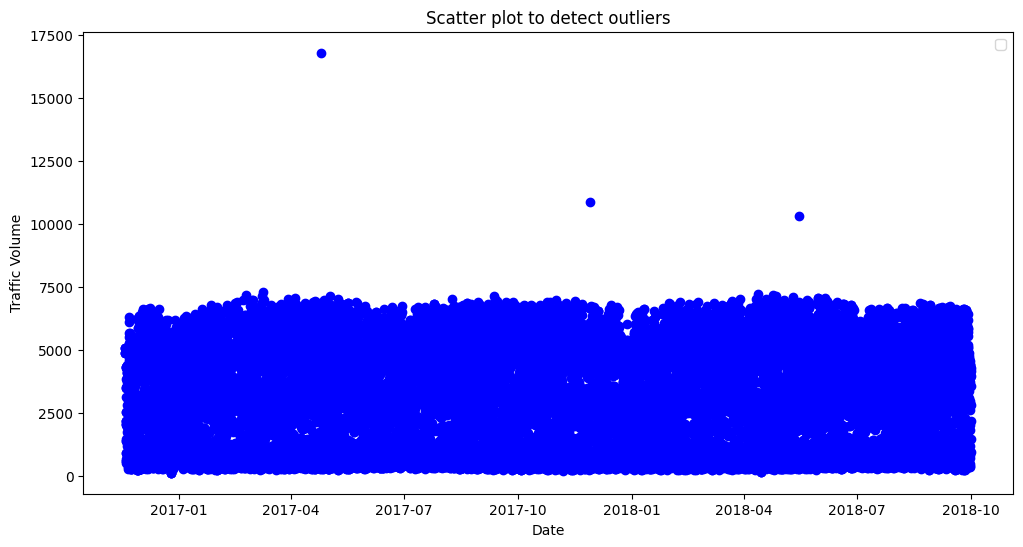

In [326]:
plt.figure(figsize=(12, 6))
plt.scatter(df.index, df['traffic_volume'], c='blue')
plt.title('Scatter plot to detect outliers')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

In [327]:
# All the previous three plots showed a little outliers so I handled them
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df = remove_outliers(df,'traffic_volume')

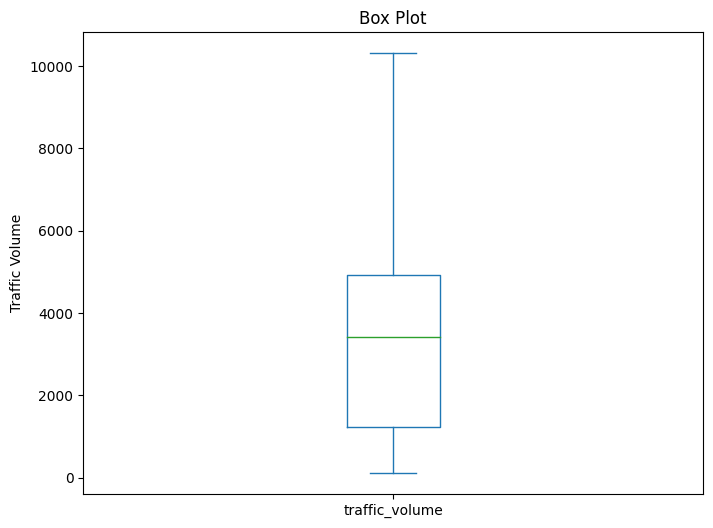

In [328]:
# To check that it's handled correctly
df['traffic_volume'].plot(kind='box', figsize=(8, 6))
plt.title('Box Plot')
plt.ylabel('Traffic Volume')
plt.show()

In [329]:
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,Lag_2_Days,Year
date_time,,,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,5,mist,316.0,2016
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,3,fog,2716.0,2016
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,7,heavy snow,3893.0,2016
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,5,mist,353.0,2016
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,7,heavy snow,2915.0,2016
...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,3543.0,283.45,0.0,0.0,75,1,broken clouds,4425.0,2018
2018-09-30 20:00:00,2781.0,282.76,0.0,0.0,90,1,overcast clouds,2517.0,2018
2018-09-30 21:00:00,2159.0,282.73,0.0,0.0,90,8,proximity thunderstorm,6232.0,2018


## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [ ]:
df['prev_traffic_volume'] = df['traffic_volume'].shift(10) # I selected 10 previous days
df['Difference between traffic volume'] = df['traffic_volume'].diff()
df['Day of the week'] = df.index.dayofweek
df['Month'] = df.index.month
df['Day of the year'] = df.index.dayofyear

In [331]:
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,Lag_2_Days,Year,prev_traffic_volume,Difference between traffic volume,Day of the week,Month,Day of the year
date_time,,,,,,,,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,5,mist,316.0,2016,NaN,NaN,4,11,323
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,3,fog,2716.0,2016,NaN,0.0,4,11,323
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,7,heavy snow,3893.0,2016,NaN,0.0,4,11,323
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,5,mist,353.0,2016,NaN,202.0,4,11,323
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,7,heavy snow,2915.0,2016,NaN,0.0,4,11,323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,3543.0,283.45,0.0,0.0,75,1,broken clouds,4425.0,2018,4049.0,-404.0,6,9,273
2018-09-30 20:00:00,2781.0,282.76,0.0,0.0,90,1,overcast clouds,2517.0,2018,4429.0,-762.0,6,9,273
2018-09-30 21:00:00,2159.0,282.73,0.0,0.0,90,8,proximity thunderstorm,6232.0,2018,4547.0,-622.0,6,9,273


## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

# Features Selection

In [332]:
# In this section I first plot a heatmap and then used Random Forest algorithm to select the most important features before splitting the data
# two approaches were used to extracting relevant features

In [333]:
# There was null values so I dropped them
df = df.dropna()

In [334]:
# I drop the 'weather_description' column because I don't think it is a primary factory (feature)
df = df.drop(['weather_description', 'snow_1h'], axis=1)

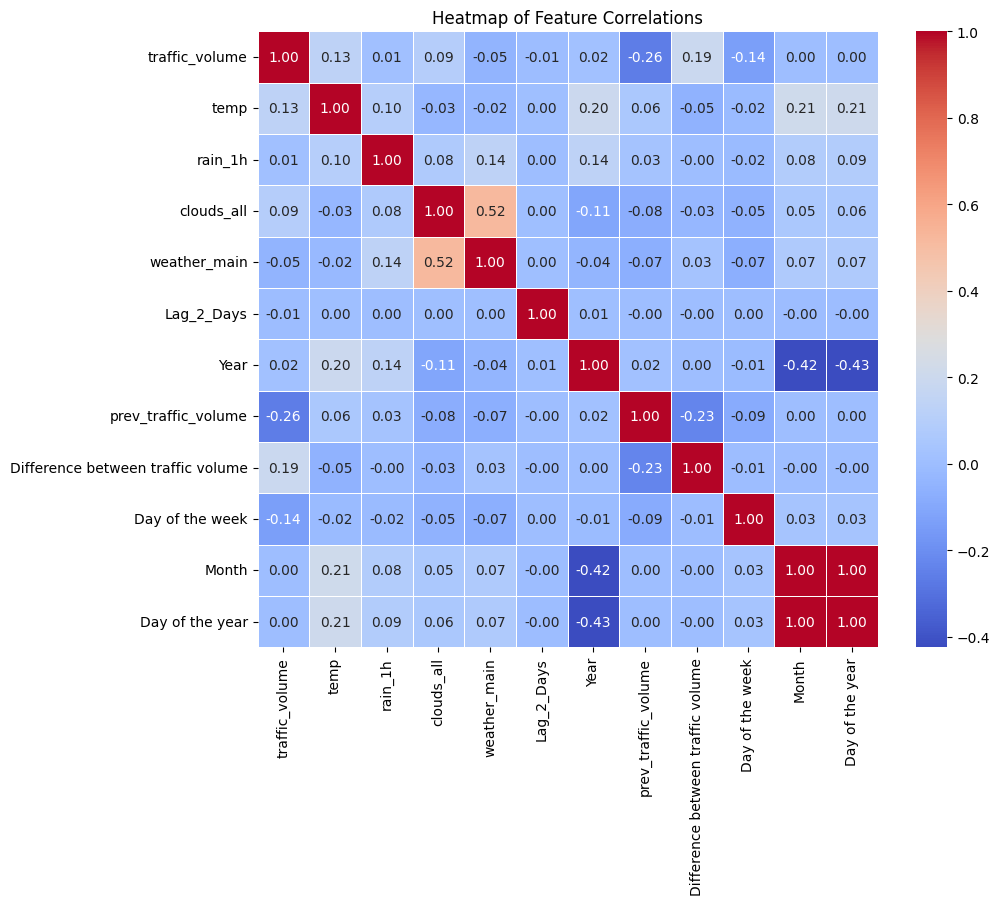

In [335]:
# Since we have many features that can be used in the training process, I plotted a heatmap to find the most relevant features.
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap of Feature Correlations')
plt.show()

In [336]:
x_train = df.drop('traffic_volume', axis=1)
y_train = df['traffic_volume']

model = RandomForestRegressor()
model.fit(x_train, y_train)

importances = model.feature_importances_

for feature, importance in zip(x_train.columns, importances):
    print(f'{feature}: {importance}')

temp: 0.11872119825053216
rain_1h: 0.004691631968777466
clouds_all: 0.07843252625337635
weather_main: 0.0628451409015794
Lag_2_Days: 0.04809510336195813
Year: 0.010521387967978614
prev_traffic_volume: 0.26068921359017355
Difference between traffic volume: 0.2461153534096731
Day of the week: 0.09648252726805116
Month: 0.01227911263607542
Day of the year: 0.06112680439182477


In [337]:
features = ['traffic_volume','temp','prev_traffic_volume', 'Difference between traffic volume']
df = df[features]
df

,traffic_volume,temp,prev_traffic_volume,Difference between traffic volume
date_time,,,,
2016-11-18 18:00:00,3486.0,273.59,4872.0,0.0
2016-11-18 19:00:00,2524.0,273.58,4872.0,-962.0
2016-11-18 19:00:00,2524.0,273.58,4872.0,0.0
2016-11-18 20:00:00,2027.0,273.28,5074.0,-497.0
2016-11-18 20:00:00,2027.0,273.28,5074.0,0.0
...,...,...,...,...
2018-09-30 19:00:00,3543.0,283.45,4049.0,-404.0
2018-09-30 20:00:00,2781.0,282.76,4429.0,-762.0
2018-09-30 21:00:00,2159.0,282.73,4547.0,-622.0


In [253]:
# For splitting the data I print the range of it, for more accurate splitting
start_date = df.index.min()
end_date = df.index.max()
print(f"Date range: {start_date} to {end_date}")

Date range: 2016-11-18 18:00:00 to 2018-09-30 23:00:00


In [254]:
train_data = df[:'2017-11-30']
test_data = df['2017-12-01':]

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [255]:
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

### **Create Sequences**

In [256]:
# For training data

X_train = []
y_train = []

# Create sequences of past observations and corresponding targets
for i in range(60, len(train_data_scaled)):
    X_train.append(train_data_scaled[i-60:i, 1:])
    y_train.append(train_data_scaled[i, 0])

X_train = np.array(X_train)
y_train = np.array(y_train)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))

In [257]:
# For testing data

X_test = []
y_test = []

for i in range(60,len(test_data_scaled)):
    X_test.append(test_data_scaled[i-60:i, 1:])
    y_test.append(test_data_scaled[i, 0])

X_test = np.array(X_test)
y_test = np.array(y_test)

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [259]:
# First model is LSTM

model = Sequential([
    layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.Dropout(0.2),

    layers.LSTM(50, return_sequences=True),
    layers.Dropout(0.2),

    layers.LSTM(50, return_sequences=True),
    layers.Dropout(0.2),

    layers.LSTM(50),
    layers.Dropout(0.2),

    layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [265]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.15, callbacks=[early_stopping])

Epoch 1/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 46s 133ms/step - loss: 0.0617 - val_loss: 0.0527
Epoch 2/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 40s 131ms/step - loss: 0.0461 - val_loss: 0.0379
Epoch 3/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - loss: 0.0368 - val_loss: 0.0262
Epoch 4/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - loss: 0.0252 - val_loss: 0.0153
Epoch 5/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 40s 135ms/step - loss: 0.0170 - val_loss: 0.0098
Epoch 6/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 40s 132ms/step - loss: 0.0131 - val_loss: 0.0089
Epoch 7/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 41s 131ms/step - loss: 0.0121 - val_loss: 0.0071
Epoch 8/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 41s 131ms/step - loss: 0.0100 - val_loss: 0.0061
Epoch 9/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 41s 131ms/step - loss: 0.0099 - val_loss: 0.0065
Epoch 10/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 41s 131ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 11/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 41s 130ms/step - loss: 0.0082 - val_loss: 0.0047
Epoch 12/20
295/295

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [267]:
predictions = model.predict(X_test)

274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step


In [270]:
original_shape = scaler.data_min_.shape
full_input = np.zeros((predictions.shape[0], original_shape[0]))
full_input[:, 0] = predictions.reshape(-1)

scaled_predict = scaler.inverse_transform(full_input)
scaled_predict = scaled_predict[:, 0]

### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [273]:
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MAE: 0.046530612620367555
MSE: 0.004442571955126724
RMSE: 0.06665262151728711


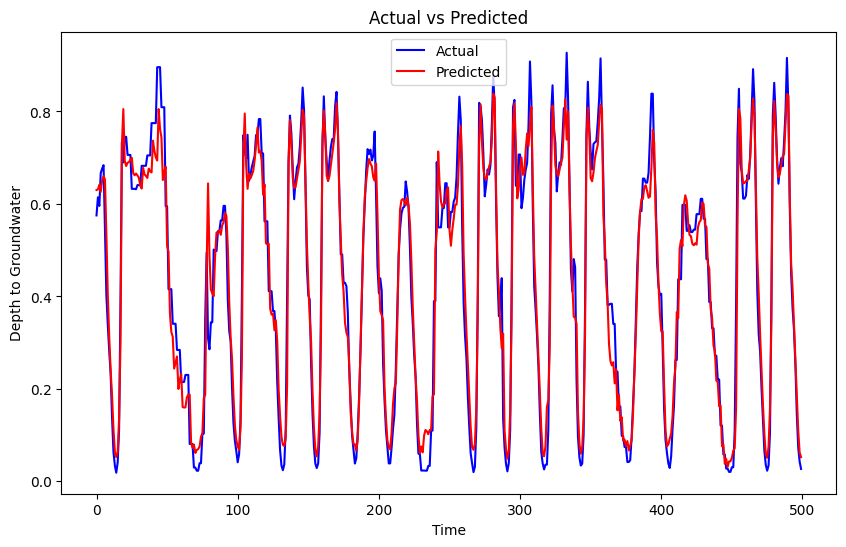

In [279]:
# I plotted only 500 sample because when I plot all samples the graph was not clear
plt.figure(figsize=(10, 6))
plt.plot(y_test[:500], color='blue', label='Actual')
plt.plot(predictions[:500], color='red', label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Depth to Groundwater')
plt.legend()
plt.show()

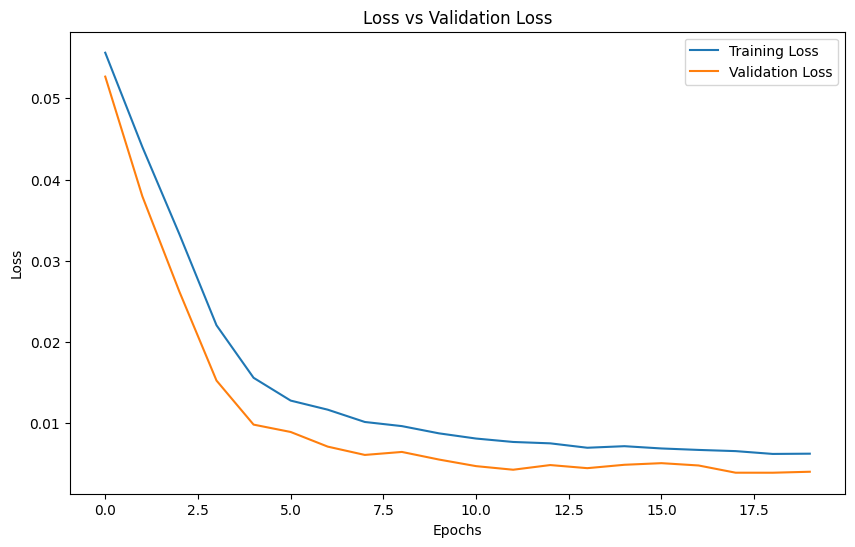

In [278]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [283]:
# Second model is GRU
model2 = Sequential([
    GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'),
    Dropout(0.2),

    GRU(units=50, return_sequences=True, activation='tanh'),
    Dropout(0.2),

    GRU(units=50, return_sequences=True, activation='tanh'),
    Dropout(0.2),

    GRU(units=50, activation='tanh'),
    Dropout(0.2),

    Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [285]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model2.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False), loss='mean_squared_error')
history2 = model2.fit(X_train, y_train, epochs = 20, batch_size=32, verbose=2, validation_split=0.15, callbacks=[early_stopping])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


295/295 - 97s - 328ms/step - loss: 0.0687 - val_loss: 0.0563
Epoch 2/20
295/295 - 83s - 280ms/step - loss: 0.0554 - val_loss: 0.0496
Epoch 3/20
295/295 - 81s - 274ms/step - loss: 0.0452 - val_loss: 0.0371
Epoch 4/20
295/295 - 82s - 277ms/step - loss: 0.0382 - val_loss: 0.0498
Epoch 5/20
295/295 - 83s - 282ms/step - loss: 0.0354 - val_loss: 0.0307
Epoch 6/20
295/295 - 81s - 274ms/step - loss: 0.0360 - val_loss: 0.0303
Epoch 7/20
295/295 - 44s - 149ms/step - loss: 0.0325 - val_loss: 0.0289
Epoch 8/20
295/295 - 82s - 278ms/step - loss: 0.0325 - val_loss: 0.0275
Epoch 9/20
295/295 - 82s - 278ms/step - loss: 0.0296 - val_loss: 0.0263
Epoch 10/20
295/295 - 81s - 275ms/step - loss: 0.0292 - val_loss: 0.0239
Epoch 11/20
295/295 - 83s - 282ms/step - loss: 0.0278 - val_loss: 0.0249
Epoch 12/20
295/295 - 81s - 274ms/step - loss: 0.0263 - val_loss: 0.0237
Epoch 13/20
295/295 - 83s - 280ms/step - loss: 0.0237 - val_loss: 0.0396
Epoch 14/20
295/295 - 82s - 279ms/step - loss: 0.0226 - val_loss: 0.016

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [286]:
predictions2 = model2.predict(X_test)

274/274 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step


In [287]:
original_shape = scaler.data_min_.shape
full_input = np.zeros((predictions2.shape[0], original_shape[0]))
full_input[:, 0] = predictions2.reshape(-1)

scaled_predict = scaler.inverse_transform(full_input)
scaled_predict = scaled_predict[:, 0]

### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [288]:
mae = mean_absolute_error(y_test, predictions2)
mse = mean_squared_error(y_test, predictions2)
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MAE: 0.08394762531387977
MSE: 0.010985849073961882
RMSE: 0.10481340121359425


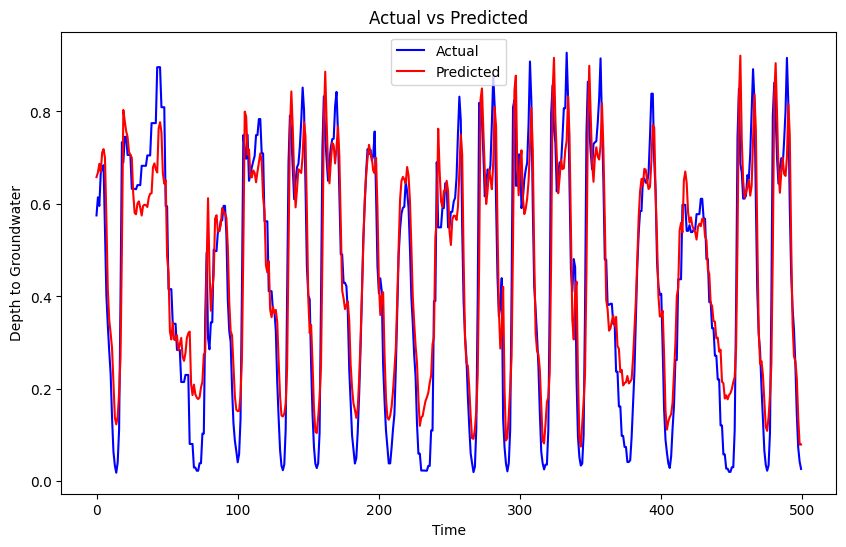

In [289]:
plt.figure(figsize=(10, 6))
plt.plot(y_test[:500], color='blue', label='Actual')
plt.plot(predictions2[:500], color='red', label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Depth to Groundwater')
plt.legend()
plt.show()

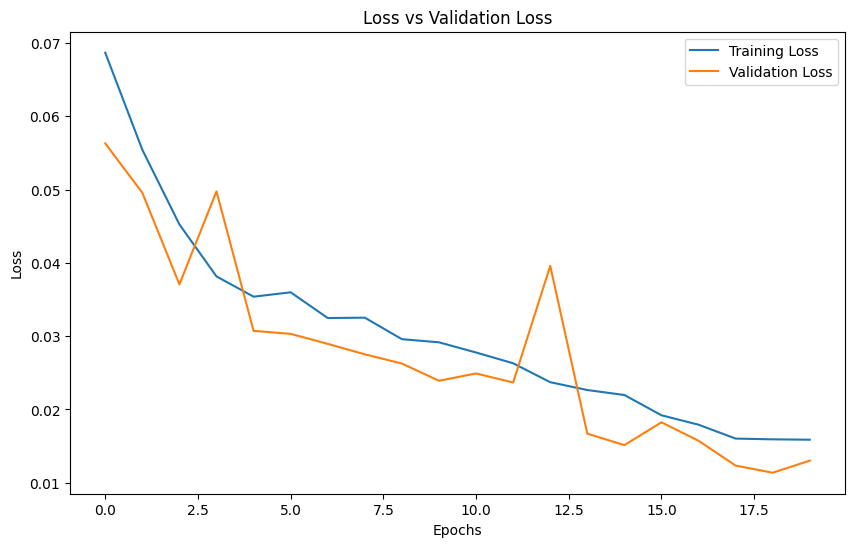

In [290]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:

1- I chose the applied preprocessing techniques because in that way the model performance will be better and more generalized. Normalization was important because data was varying in scale which affects the learning process of the model.




2- I created more than one of the new features but the one that I used in the model was 'Difference between traffic volume' and 'prev_traffic_volume' and I found that they had an effect on the target column 'traffic_volume'.




3- It gives me high accuracy, and I used LSTM and GRU because they can save long memory which is beneficial in time-series analysis.




4- These hyperparameters give the best accuracy




5- Because they are used in regression tasks which is the objective of forecasting (traffic volume forecasting).




6- I applied fine-tuning on the number of units in the model and batch size and I found that the existing ones now are suitable.




7- Both models do not suffer from overfitting or underfitting but if they did I might use cross-validation, regularization and over or under sampling.




8- I might try different hyperparameters or use another model architecture, or we can use ensemple methods.